## Senior Thesis Chapter 3 Clustering Code

#### Justin Kaashoek

This notebook is structure in the following 

(1) Importing packages

(2) Read and clean daily death data

(3) Clustering

## Section 1: Packages

In [23]:
# Import packages

# Numpy and pandas
import pandas as pd
import numpy as np

# Plotting packages
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from matplotlib import font_manager as fm, rcParams

# Clustering and math packages
import scipy
from scipy import stats
from scipy.cluster.hierarchy import fcluster
from tslearn.clustering import TimeSeriesKMeans
import scipy.cluster.hierarchy as hac

# Misc
import os
from math import *

In [9]:
## Constants

# Number of days to smooth data
SMOOTH = 7

In [10]:
# Point to font file -- my local font file settings gave me a lot of problems 
fpath = os.path.join(rcParams["datapath"], "fonts/ttf/Helvetica.ttf")
prop = fm.FontProperties(fname=fpath)

In [11]:
# Set some plotting params
# This is largely from https://jwalton.info/Embed-Publication-Matplotlib-Latex/
sns.set(
        rc={
 "axes.axisbelow": True,
 "axes.edgecolor": "lightgrey",
 "axes.facecolor": "None",
 "axes.grid": False,
 "axes.labelcolor": "#1D1C1C",
 "axes.spines.right": False,
 "axes.spines.top": False,
 "figure.facecolor": "white",
 "lines.solid_capstyle": "round",
 "patch.edgecolor": "w",
 "patch.force_edgecolor": True,
 "text.color": "#1D1C1C",
 "xtick.color": "#1D1C1C",
 "xtick.direction": "out",
 "ytick.color": "#1D1C1C",
 "ytick.direction": "out"})
sns.set_context("notebook", rc={"font.size":16,
                                "axes.titlesize":20,
                                "axes.labelsize":18})
sns.color_palette('Paired')

## Section 2: Read data and clean

In [12]:
# Read in John's Hopkins data

county_cases = pd.read_csv("../data/time_series_covid19_confirmed_US.csv")
county_deaths = pd.read_csv("../data/time_series_covid19_deaths_US.csv")


county_cases.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,2/3/21,2/4/21,2/5/21,2/6/21,2/7/21,2/8/21,2/9/21,2/10/21,2/11/21,2/12/21
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,...,5753,5811,5824,5856,5869,5881,5910,5930,5970,5984
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,...,18418,18494,18568,18668,18723,18763,18824,18888,18960,18994
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,...,1981,1989,1994,2002,2008,2008,2019,2024,2030,2036
3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,...,2321,2327,2331,2334,2339,2346,2362,2368,2377,2385
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,...,5768,5842,5871,5908,5915,5920,5929,5937,5955,5953


In [13]:
# Uncomment to use deaths

county_cases = county_deaths.copy()

In [14]:
# Filter out just to get to the 50 states + District of Columbia
provinces = list(county_cases.Province_State.unique())
to_remove = ['Diamond Princess', 'Guam', 'Grand Princess', 'Northern Mariana Islands', 'Puerto Rico', 'Virgin Islands', 
             'American Samoa']
states = [x for x in provinces if x not in to_remove]
county_cases = county_cases[county_cases.Province_State.isin(states)]
county_cases = county_cases[county_cases.Population > 0]
county_cases.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,2/3/21,2/4/21,2/5/21,2/6/21,2/7/21,2/8/21,2/9/21,2/10/21,2/11/21,2/12/21
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,...,71,74,76,77,77,77,77,79,81,84
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,...,228,233,234,227,227,227,228,239,240,251
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,...,42,43,44,45,45,45,45,46,46,48
3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,...,52,52,52,53,53,53,53,54,54,57
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,...,105,109,111,112,112,112,113,116,116,121


In [15]:
# Drop any rows that do not have a FIPS (unique county identifier) ID

county_cases = county_cases[~county_cases.FIPS.isna()].reset_index(drop=True)
county_cases.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,2/3/21,2/4/21,2/5/21,2/6/21,2/7/21,2/8/21,2/9/21,2/10/21,2/11/21,2/12/21
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,...,71,74,76,77,77,77,77,79,81,84
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,...,228,233,234,227,227,227,228,239,240,251
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,...,42,43,44,45,45,45,45,46,46,48
3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,...,52,52,52,53,53,53,53,54,54,57
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,...,105,109,111,112,112,112,113,116,116,121


In [16]:
# Remove counties with no cases
dates = county_cases.columns[12:]
print(dates)

# Array to hold indices
zero_cases = []

# Find all counties with no cases
for i in range(len(county_cases)):
    if np.all(county_cases[dates].values[i] == 0):
        zero_cases.append(i)

county_cases = county_cases.drop(zero_cases, axis=0)
county_cases.head()

Index(['1/22/20', '1/23/20', '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       '1/28/20', '1/29/20', '1/30/20', '1/31/20',
       ...
       '2/3/21', '2/4/21', '2/5/21', '2/6/21', '2/7/21', '2/8/21', '2/9/21',
       '2/10/21', '2/11/21', '2/12/21'],
      dtype='object', length=388)


,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,2/3/21,2/4/21,2/5/21,2/6/21,2/7/21,2/8/21,2/9/21,2/10/21,2/11/21,2/12/21
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,...,71,74,76,77,77,77,77,79,81,84
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,...,228,233,234,227,227,227,228,239,240,251
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,...,42,43,44,45,45,45,45,46,46,48
3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,...,52,52,52,53,53,53,53,54,54,57
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,...,105,109,111,112,112,112,113,116,116,121


In [17]:
# Get the number of new cases per day, casting anything that is less than 0 (or nan values) to 0

# These are the columns we want to keep on top of the date columns
keep_cols= ["FIPS", "Population", "Province_State", "Admin2"]

new_cases = county_cases[keep_cols+[dates[0]]].copy()
for i in range(1, len(dates)):
    curr_date = dates[i]
    last_date = dates[i-1]
    diff = county_cases[curr_date] - county_cases[last_date]
    new_cases[curr_date] = np.where((diff >= 0), diff, 0) 

new_cases.head()

,FIPS,Population,Province_State,Admin2,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,2/3/21,2/4/21,2/5/21,2/6/21,2/7/21,2/8/21,2/9/21,2/10/21,2/11/21,2/12/21
0,1001.0,55869,Alabama,Autauga,0,0,0,0,0,0,...,1,3,2,1,0,0,0,2,2,3
1,1003.0,223234,Alabama,Baldwin,0,0,0,0,0,0,...,0,5,1,0,0,0,1,11,1,11
2,1005.0,24686,Alabama,Barbour,0,0,0,0,0,0,...,2,1,1,1,0,0,0,1,0,2
3,1007.0,22394,Alabama,Bibb,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,3
4,1009.0,57826,Alabama,Blount,0,0,0,0,0,0,...,4,4,2,1,0,0,1,3,0,5


In [18]:
# Apply a smoothing by averaging over the last SMOOTH number of days

smoothed_df = county_cases[keep_cols].copy()
for i in range(SMOOTH-1, len(dates)):
    sm_range = dates[i-SMOOTH+1:i+1]
    smoothed_df[dates[i]] = np.mean(new_cases[sm_range], axis=1)

smoothed_df.head()            

,FIPS,Population,Province_State,Admin2,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,...,2/3/21,2/4/21,2/5/21,2/6/21,2/7/21,2/8/21,2/9/21,2/10/21,2/11/21,2/12/21
0,1001.0,55869,Alabama,Autauga,0.0,0.0,0.0,0.0,0.0,0.0,...,0.571429,0.714286,1.000000,1.142857,1.142857,1.142857,1.000000,1.142857,1.000000,1.142857
1,1003.0,223234,Alabama,Baldwin,0.0,0.0,0.0,0.0,0.0,0.0,...,1.714286,1.285714,1.428571,1.428571,1.428571,1.428571,1.000000,2.571429,2.000000,3.428571
2,1005.0,24686,Alabama,Barbour,0.0,0.0,0.0,0.0,0.0,0.0,...,0.285714,0.428571,0.571429,0.714286,0.714286,0.714286,0.714286,0.571429,0.428571,0.571429
3,1007.0,22394,Alabama,Bibb,0.0,0.0,0.0,0.0,0.0,0.0,...,0.142857,0.142857,0.142857,0.285714,0.142857,0.142857,0.142857,0.285714,0.285714,0.714286
4,1009.0,57826,Alabama,Blount,0.0,0.0,0.0,0.0,0.0,0.0,...,1.428571,1.571429,1.857143,2.000000,1.714286,1.714286,1.714286,1.571429,1.000000,1.428571


In [21]:
# Set this to the dataframe to be used and the date range

df = smoothed_df.copy()
date_range = dates[SMOOTH-1:]
n_days = len(date_range)
m = n_days

## Section 3: Clustering

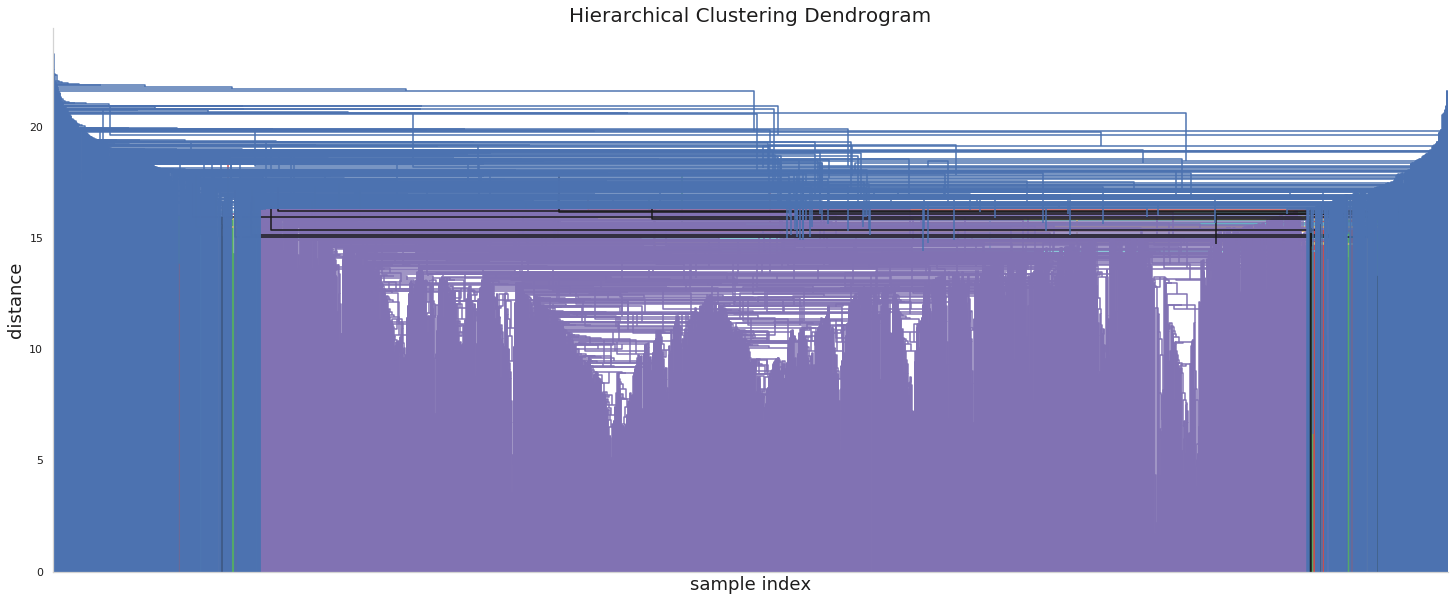

In [24]:
# Z-score all the data

# Data matrices
all_data = df[date_range].values
data = scipy.stats.zscore(all_data, axis=1)

# Perform HAC clustering
Z = hac.linkage(data, method='centroid', metric='euclidean')

# Plot dendogram - hard to interpret so we show explore clusters a little more
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
hac.dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.xticks([])
plt.show()

In [26]:
def print_clusters(Z, k):
    '''
    Function to get the number of clusters based on the hac clustering (Z) and the number of requested clusters (k)
    '''
    # k Number of clusters I'd like to extract
    results = fcluster(Z, k, criterion='maxclust')

    # check the results
    s = pd.Series(results)
    clusters = s.unique()

    for c in clusters:
        cluster_indeces = s[s==c].index
        print("Cluster %d number of entries %d" % (c, len(cluster_indeces)))

# We see that all counties are basically but into one cluster - not ideal
print_clusters(Z, 3)

Cluster 1 number of entries 3063
Cluster 3 number of entries 1
Cluster 2 number of entries 1


In [29]:
## We'll not try k-means, first running for k from 1 to 2 to generate an elbow pot

errors = []
for k in range(1, 20):
    # We use tslearn's packages because it allows us to change the metric to dynamic time warping
    kmeans = TimeSeriesKMeans(n_clusters=k, metric='euclidean', random_state=10).fit(data)
    errors.append(kmeans.inertia_)

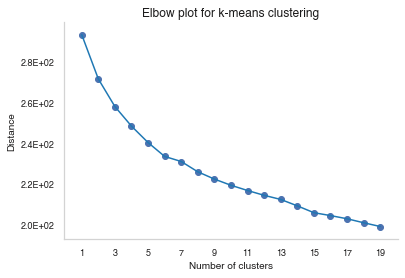

In [31]:
# Construct elbow plot
f = plt.figure()
ax = f.add_subplot(111)
ax.plot(errors, color='#1f78b4')
ax.set_xticks([i for i in range(0,19)][::2])
ax.set_xticklabels([i+1 for i in range(0,19)][::2], fontproperties=prop, fontsize=9)
ax.scatter([i for i in range(len(errors))], errors)
ax.set_yticklabels(['%.1E'%(q) for q in ax.get_yticks()], fontproperties=prop, fontsize=9)
ax.set_xlabel("Number of clusters", fontproperties=prop, fontsize=10)
ax.set_ylabel("Distance", fontproperties=prop, fontsize=10)
ax.set_title("Elbow plot for k-means clustering", fontproperties=prop, fontsize=12)
sns.despine(top=True, bottom=False, left=False, right=True)
plt.savefig("../figures/chapter_3/clustering/elbow_plot.pdf", dpi=150, bbox_inches='tight')
plt.show()

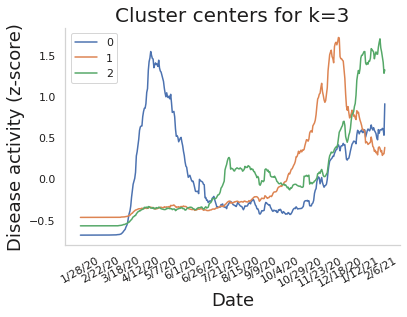

In [32]:
# Choose k and run a more rigorous clustering using 10 random starts
k=3
kmeans = TimeSeriesKMeans(n_clusters=k, metric='euclidean', n_init=10, random_state=10).fit(data)
centers = kmeans.cluster_centers_
centers = centers.reshape(centers.shape[0], centers.shape[1])


plt.figure()
for i in range(k):
    plt.plot(centers.T[:,i], label=str(i))
plt.title("Cluster centers for k=%i"%(k))
plt.xticks([i for i in range(len(date_range))][::25], date_range[::25], rotation=30)
plt.xlabel("Date")
plt.ylabel("Disease activity (z-score)")
plt.legend(frameon=False)
plt.savefig('../figures/chapter_3/clustering/centers_k%i.png'%(k), dpi=300, bbox_inches='tight')
plt.show()

In [33]:
# Write the cluster centers to the centers.csv dataframe
cents = pd.DataFrame(centers, columns=date_range)
cents.to_csv("../data/centers.csv", index=False)
cents.head()

,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,...,2/3/21,2/4/21,2/5/21,2/6/21,2/7/21,2/8/21,2/9/21,2/10/21,2/11/21,2/12/21
0,-0.684340,-0.684340,-0.684340,-0.684340,-0.684340,-0.684340,-0.684340,-0.684340,-0.684340,-0.684340,...,0.473933,0.597677,0.552666,0.592342,0.597378,0.593339,0.612904,0.601000,0.529571,0.911169
1,-0.468868,-0.468868,-0.468868,-0.468868,-0.468868,-0.468868,-0.468868,-0.468868,-0.468868,-0.468868,...,0.291020,0.377347,0.387957,0.370984,0.328265,0.344152,0.283944,0.305530,0.304611,0.380994
2,-0.571420,-0.571420,-0.571420,-0.571420,-0.571420,-0.571420,-0.571420,-0.571420,-0.571420,-0.571420,...,1.513527,1.600142,1.657556,1.700384,1.589730,1.542793,1.476159,1.415303,1.282084,1.322536


In [34]:
# Assign clusters and slightly alter our fips ids so that they all have leading zeros
df['cluster'] = kmeans.labels_
df['fips'] = df['FIPS'].astype(int).astype(str)
df['fips'] = [x.zfill(5) for x in df.fips]
# Write to file for use in political_analysis.ipynb
df[['FIPS', 'cluster']].to_csv("../data/cluster_assignment.csv", index=False)
df.head()

,FIPS,Population,Province_State,Admin2,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,...,2/5/21,2/6/21,2/7/21,2/8/21,2/9/21,2/10/21,2/11/21,2/12/21,cluster,fips
0,1001.0,55869,Alabama,Autauga,0.0,0.0,0.0,0.0,0.0,0.0,...,1.000000,1.142857,1.142857,1.142857,1.000000,1.142857,1.000000,1.142857,2,01001
1,1003.0,223234,Alabama,Baldwin,0.0,0.0,0.0,0.0,0.0,0.0,...,1.428571,1.428571,1.428571,1.428571,1.000000,2.571429,2.000000,3.428571,2,01003
2,1005.0,24686,Alabama,Barbour,0.0,0.0,0.0,0.0,0.0,0.0,...,0.571429,0.714286,0.714286,0.714286,0.714286,0.571429,0.428571,0.571429,1,01005
3,1007.0,22394,Alabama,Bibb,0.0,0.0,0.0,0.0,0.0,0.0,...,0.142857,0.285714,0.142857,0.142857,0.142857,0.285714,0.285714,0.714286,1,01007
4,1009.0,57826,Alabama,Blount,0.0,0.0,0.0,0.0,0.0,0.0,...,1.857143,2.000000,1.714286,1.714286,1.714286,1.571429,1.000000,1.428571,2,01009
